In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Define

In [2]:
#TRAIN_DATA_FILES = ['cross','dead', 'left', 'right', 'straight', 'threeway']
#TRAIN_DATA_FILES = ['straight']
TRAIN_DATA_FILES = ['2-18F-50cm']
# NUM_CLASSES = 6
NUM_CLASSES = len(TRAIN_DATA_FILES)

MAX_ANGLE = 240
MAX_RANGE = 4 #[m]
LIDAR_HZ = 4.0

NUM_READ_DATA = 400
REPLACE_NAN = 0.0

MAKE_DECIMAL = 1000
MAP_BUILD_HZ = 1.0
MAX_SPEED = 1.0
MARGIN = 1.5
RESOLUTION = 0.5 #[m]
WIDTH = HEIGHT = int(2*(1/RESOLUTION * (MAX_RANGE + MAX_SPEED/MAP_BUILD_HZ))*MARGIN)
ROBOT_ORIGIN = (np.trunc(WIDTH/2)+(np.trunc(HEIGHT/2)/MAKE_DECIMAL))


## 学習データ数の読み込み用関数  
データ読み込み時、それぞれのラベルの学習データの内、最も数の少ないものに合わせる

In [3]:
def adjust_data_num(num_class):
    # header = 列名
    file_name = "./data/" + TRAIN_DATA_FILES[num_class] + '.csv'
    data_set = pd.read_csv(file_name, header=None)

#    return data_set.head(NUM_READ_DATA)
    return data_set

## 学習データ読み込み用関数

In [4]:
def split_data():
    files = os.listdir('./data')
    X = []
    all_data_set = []

    for i in range(NUM_CLASSES):
        try:
            data_set = adjust_data_num(i)
            all_data_set.append(data_set)

        except pd.io.common.EmptyDataError:
            print("ERROR: {} is empty".format(file_name))

    X = pd.concat(all_data_set)
    # replace Nan with 'REPLACE_NAN'
    X = X.fillna(REPLACE_NAN)

#    _, dim_input_data = data_set.shape

    return X.values

## 計算  
距離データ →点群

In [5]:
def calc_point_cloud(lidar_data):
    resized_lidar_data = lidar_data / RESOLUTION
    dim_input_data = resized_lidar_data.shape[0]

    sin_table4x = [ [-np.sin(np.deg2rad((-MAX_ANGLE/2) + (i / dim_input_data * MAX_ANGLE))) for i in range(dim_input_data)]  ]
    cos_table4y = [ [np.cos(np.deg2rad((-MAX_ANGLE/2) + (j / dim_input_data * MAX_ANGLE))) for j in range(dim_input_data)]  ]
    
    point_cloud_x = np.round(resized_lidar_data * sin_table4x) + (WIDTH / 2)
    point_cloud_y = np.round(resized_lidar_data * cos_table4y) + (HEIGHT / 2)

    return point_cloud_x, point_cloud_y

## 重複した座標&robotの原点削除  
整数部分にxの値を、小数部分にyの値を入れてnp.uniqueでダブりを削除

In [23]:
def unique_point_cloud(point_cloud_x, point_cloud_y):
    point_cloud_concatenate = np.trunc(point_cloud_x) + (np.trunc(point_cloud_y)/MAKE_DECIMAL)

    print(np.sort(point_cloud_concatenate), "\n")
    
    point_cloud_concatenate_unique = np.unique(point_cloud_concatenate)
    point_cloud_concatenate_unique = np.delete(point_cloud_concatenate_unique, np.where(point_cloud_concatenate_unique==ROBOT_ORIGIN), axis=0)

    print(np.sort(point_cloud_concatenate_unique))

    # trunc=小数点以下切り捨て
    point_cloud_x_unique = np.trunc(point_cloud_concatenate_unique)
    point_cloud_y_unique = (point_cloud_concatenate_unique - point_cloud_x_unique) * MAKE_DECIMAL

    return point_cloud_x_unique.astype(np.int32), point_cloud_y_unique.astype(np.int32)

## インデックスを返す関数  
grid mapを作成する際に使用  
2次元の配列を1次元で表現したときのインデックスを返す

In [7]:
def return_index(point_cloud_x, point_cloud_y):
    return HEIGHT*point_cloud_y + point_cloud_x

## grid img作成関数

In [8]:
def make_grid_map(point_cloud_x, point_cloud_y):
    fig, ax = plt.subplots(figsize=(5, 5))
    grid_map1D = np.zeros(int(HEIGHT*WIDTH))
    map_point_cloud1D = return_index(point_cloud_x, HEIGHT-point_cloud_y).astype(np.int32)
    grid_map1D[map_point_cloud1D] = 255.0
    grid_map = np.reshape(grid_map1D, (HEIGHT, WIDTH))

    return grid_map

## Plot

In [9]:
def plot_point_cloud(point_cloud_x, point_cloud_y, color="k"):
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.scatter(point_cloud_x, point_cloud_y, color=color)
    ax.set_xlim(0, WIDTH)
    ax.set_ylim(0, HEIGHT)

#    plt.axis("off")
    #plt.savefig("result.png", transparent = True)
    plt.show()

## 回転＆並進移動

In [10]:
def trans_point_cloud(point_cloud_x, point_cloud_y, dx=0, dy=0, dtheta=0):
    rotation_vector = np.array([[np.cos(dtheta), -np.sin(dtheta)], [np.sin(dtheta), np.cos(dtheta)]], dtype=np.float32)
    point_cloud_XY = np.c_[point_cloud_x-(WIDTH/2), point_cloud_y-(HEIGHT/2)].T
    trans_point_cloud = np.dot(rotation_vector, point_cloud_XY)
    trans_point_cloud_x = trans_point_cloud[0] + (WIDTH/2) + (dx/RESOLUTION)
    trans_point_cloud_y = trans_point_cloud[1] + (HEIGHT/2) + (dy/RESOLUTION)
    
    return trans_point_cloud_x, trans_point_cloud_y

# main

In [11]:
lidar_data = split_data()

plot with matplotlib


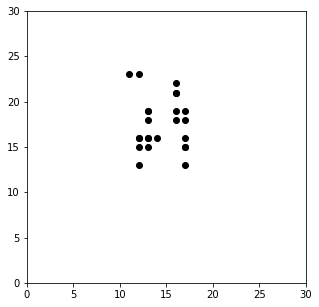

show grid map
show grid map after rotation and translation


<function matplotlib.pyplot.show(*args, **kw)>

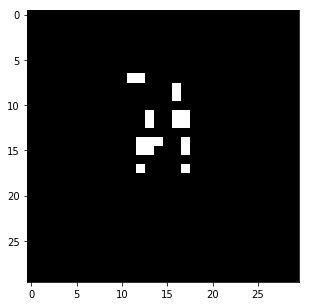

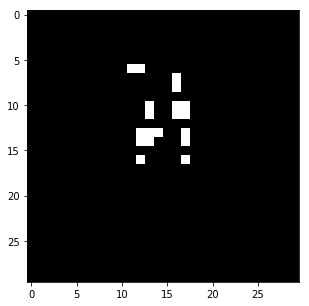

In [12]:
index = 1
prev_point_cloud_x, prev_point_cloud_y = calc_point_cloud(lidar_data[index])
prev_point_cloud_x_unique, prev_point_cloud_y_unique = unique_point_cloud(prev_point_cloud_x, prev_point_cloud_y)

print("plot with matplotlib")
plot_point_cloud(prev_point_cloud_x_unique, prev_point_cloud_y_unique)

print("show grid map")
prev_grid_map = make_grid_map(prev_point_cloud_x_unique, prev_point_cloud_y_unique)
plt.imshow(prev_grid_map)
plt.gray()
plt.show

print("show grid map after rotation and translation")
prev_trans_point_cloud_x, prev_trans_point_cloud_y = trans_point_cloud(prev_point_cloud_x_unique, prev_point_cloud_y_unique, 0, 0.5, np.deg2rad(0))
grid_map = make_grid_map(prev_trans_point_cloud_x.astype(np.int32), prev_trans_point_cloud_y.astype(np.int32))
plt.imshow(grid_map)
plt.gray()
plt.show


plot with matplotlib


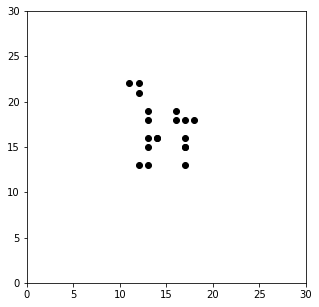

show grid map


<function matplotlib.pyplot.show(*args, **kw)>

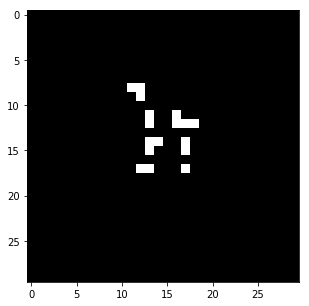

In [13]:
index = 148
point_cloud_x, point_cloud_y = calc_point_cloud(lidar_data[index])
point_cloud_x_unique, point_cloud_y_unique = unique_point_cloud(point_cloud_x, point_cloud_y)

print("plot with matplotlib")
plot_point_cloud(point_cloud_x_unique, point_cloud_y_unique)

print("show grid map")
grid_map = make_grid_map(point_cloud_x_unique, point_cloud_y_unique)
plt.imshow(grid_map)
plt.gray()
plt.show
 

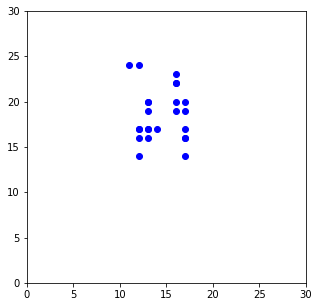

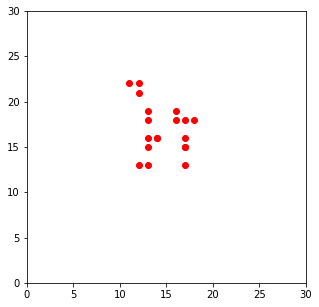

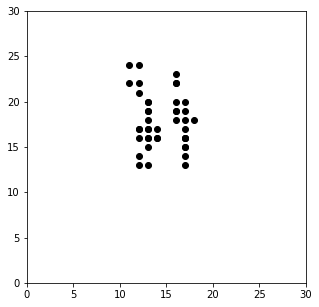

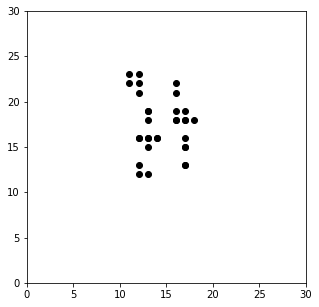

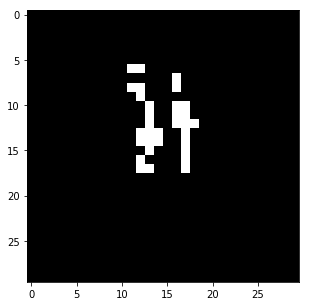

In [14]:
merged_point_cloud_x = np.append(prev_trans_point_cloud_x, point_cloud_x_unique)
merged_point_cloud_y = np.append(prev_trans_point_cloud_y, point_cloud_y_unique)

plot_point_cloud(prev_trans_point_cloud_x, prev_trans_point_cloud_y, color="b")
plot_point_cloud(point_cloud_x_unique, point_cloud_y_unique, color="r")
plot_point_cloud(merged_point_cloud_x, merged_point_cloud_y)

merged_point_cloud_x_unique, merged_point_cloud_y_unique = unique_point_cloud(merged_point_cloud_x, merged_point_cloud_y)
plot_point_cloud(merged_point_cloud_x_unique, merged_point_cloud_y_unique)

merged_grid_map = make_grid_map(merged_point_cloud_x, merged_point_cloud_y)
plt.imshow(merged_grid_map)
plt.gray()
plt.show()

In [33]:
merged_point_cloud_x = np.append(np.sort(prev_trans_point_cloud_x), np.sort(point_cloud_x_unique))
merged_point_cloud_y = np.append(np.sort(prev_trans_point_cloud_y), np.sort(point_cloud_y_unique))



[11.022 12.013 12.021 12.022 13.013 13.015 13.016 13.018 13.019 14.016
 14.016 16.018 16.019 17.013 17.015 17.015 17.016 17.018 18.018] 

[11.022 12.013 12.021 12.022 13.013 13.015 13.016 13.018 13.019 14.016
 16.018 16.019 17.013 17.015 17.016 17.018 18.018]


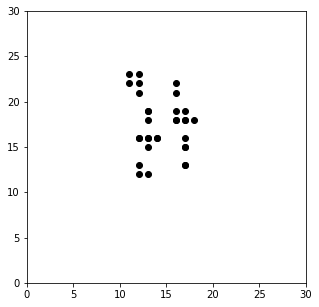

In [24]:
point_cloud_x_unique2, point_cloud_y_unique2 = unique_point_cloud(point_cloud_x_unique, point_cloud_y_unique)
plot_point_cloud(merged_point_cloud_x_unique, merged_point_cloud_y_unique)


In [18]:
print(np.sort(point_cloud_x_unique))
print(np.sort(point_cloud_y_unique))
print()
print(np.sort(point_cloud_x_unique2))
print(np.sort(point_cloud_y_unique2))


[11 12 12 12 13 13 13 13 13 14 14 16 16 17 17 17 17 17 18]
[13 13 13 15 15 15 16 16 16 16 18 18 18 18 19 19 21 22 22]

[11 12 12 12 13 13 13 13 13 14 16 16 17 17 17 17 18]
[12 12 13 15 15 15 16 16 18 18 18 18 18 19 21 22 22]
